In [1]:
import numpy as np
from MainFunctions import *
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [2]:
#original 512 x 512
i_width = 32
i_height = 32
input_shape = i_width*i_height
print(input_shape)

1024


In [3]:
x_trn = []
x_tst = []

AddImageToArray(x_trn ,'DICOM\skulls\skull8', (i_width, i_height))
AddImageToArray(x_tst ,'DICOM\PA5\ST1\SE4', (i_width, i_height))

x_trn = np.array(x_trn, np.float32)
x_tst = np.array(x_tst, np.float32)

In [4]:
max_value = np.max(x_trn)
print(max_value)
x_trn /= max_value
x_tst /= max_value

showing_ratio = 0.05
y_trn = np.where(x_trn > showing_ratio, 1.0, 0.0)
y_trn = np.array(y_trn, np.float32)

print(len(x_trn ))
print(x_trn.shape)
print(x_trn[0].max())

1422.8953
234
(234, 32, 32)
0.18031381


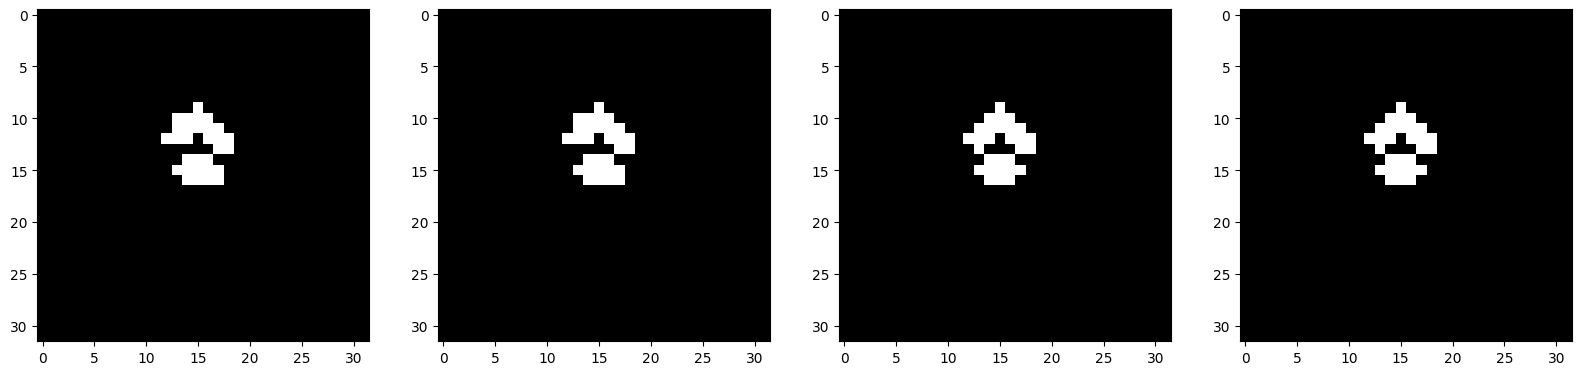

In [5]:
plt.figure(figsize=(25,25))
DrawImages(y_trn, 4, (5,5), 40)

In [52]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
    
class offset_block(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2,)
        self.dropout = nn.Dropout(p=0.2)
        self.flatten = nn.Flatten()
        self.fully_connected = nn.Linear(512, input_shape)
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        x = self.max_pool(inputs)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fully_connected(x)
        x = self.sigmoid(x)
        return x

In [53]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e0 = encoder_block(1, 32)
        self.e1 = encoder_block(32, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        """ Bottleneck """
        self.b1 = conv_block(256, 512)
        self.b2 = conv_block(512, 512)
        """OffsetClassification"""
        self.off = offset_block(512)
        """ Decoder """
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        self.d5 = decoder_block(64, 32)
        """ Classifier """
        self.outputs1 = nn.Conv2d(32, 32, kernel_size=1, padding=0)
        self.outputs2 = nn.Conv2d(32, 1, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        """ Encoder """
        s0, p0 = self.e0(inputs)
        s1, p1 = self.e1(p0)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        """ Bottleneck """
        b1 = self.b1(p3)
        b2 = self.b2(b1)
        """OffsetClassification"""
        off = self.off(b2)
        off = off.view(-1, i_height, i_width)
        """ Decoder """
        d2 = self.d2(b2, s3)
        d3 = self.d3(d2,s2)
        d4 = self.d4(d3,s1)
        d5 = self.d5(d4, s0)
        """ Classifier """
        outputs = self.outputs1(d5)
        outputs = self.outputs2(outputs)
        outputs = self.sigmoid(outputs)
        return off + outputs

In [54]:
#use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = build_unet().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [55]:
def train(epochs, model, criterion, optimizer, train_loader, eps):
    for epoch in range(epochs):
        loss = 0
        for batch_features, targets in train_loader:

            batch_features = batch_features.view(-1, 1, i_height, i_width).to(device) #.view(-1, 1, i_height, i_width)
            targets = targets.view(-1, 1, i_height, i_width).to(device)
            optimizer.zero_grad()
            
            # compute reconstructions
            outputs = model(batch_features)
            # compute training reconstruction loss
            train_loss = criterion(outputs, targets)
            
            # compute accumulated gradients
            train_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
        
        # compute the epoch training loss
        loss = loss / len(train_loader)
        
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
        if loss < eps:
            break
    
    return model

In [56]:
train_loader = torch.utils.data.DataLoader(
    (x_trn, x_trn), batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    x_trn, batch_size=32, shuffle=False
)

In [57]:
model = train(1000, model, criterion, optimizer, train_loader, 0.003)

epoch : 1/1000, loss = 2.561887
epoch : 2/1000, loss = 2.063009
epoch : 3/1000, loss = 1.730243
epoch : 4/1000, loss = 1.490948
epoch : 5/1000, loss = 1.357818
epoch : 6/1000, loss = 1.278059
epoch : 7/1000, loss = 1.226414
epoch : 8/1000, loss = 1.188182
epoch : 9/1000, loss = 1.158938
epoch : 10/1000, loss = 1.136915
epoch : 11/1000, loss = 1.116997
epoch : 12/1000, loss = 1.099955
epoch : 13/1000, loss = 1.085391
epoch : 14/1000, loss = 1.071338
epoch : 15/1000, loss = 1.059610
epoch : 16/1000, loss = 1.049487
epoch : 17/1000, loss = 1.038555
epoch : 18/1000, loss = 1.030050
epoch : 19/1000, loss = 1.021102
epoch : 20/1000, loss = 1.012064
epoch : 21/1000, loss = 1.004562
epoch : 22/1000, loss = 0.997871
epoch : 23/1000, loss = 0.990611
epoch : 24/1000, loss = 0.984254
epoch : 25/1000, loss = 0.977723
epoch : 26/1000, loss = 0.972613
epoch : 27/1000, loss = 0.966149
epoch : 28/1000, loss = 0.961154
epoch : 29/1000, loss = 0.955875
epoch : 30/1000, loss = 0.950748
epoch : 31/1000, lo

KeyboardInterrupt: 

In [58]:
test_examples = [[]]
reconstruction = []
with torch.no_grad():
    batch_features = torch.asarray(x_tst)
    test_examples = np.array(x_tst)
    batch_features = batch_features.view(-1, 1, i_height, i_width).to(device)
    reconstruction = np.array(model(batch_features)).reshape(-1, i_height, i_width)

print(test_examples.shape)
print(reconstruction.shape)

(261, 32, 32)
(68121, 32, 32)


0.5734387


<Figure size 2500x2500 with 0 Axes>

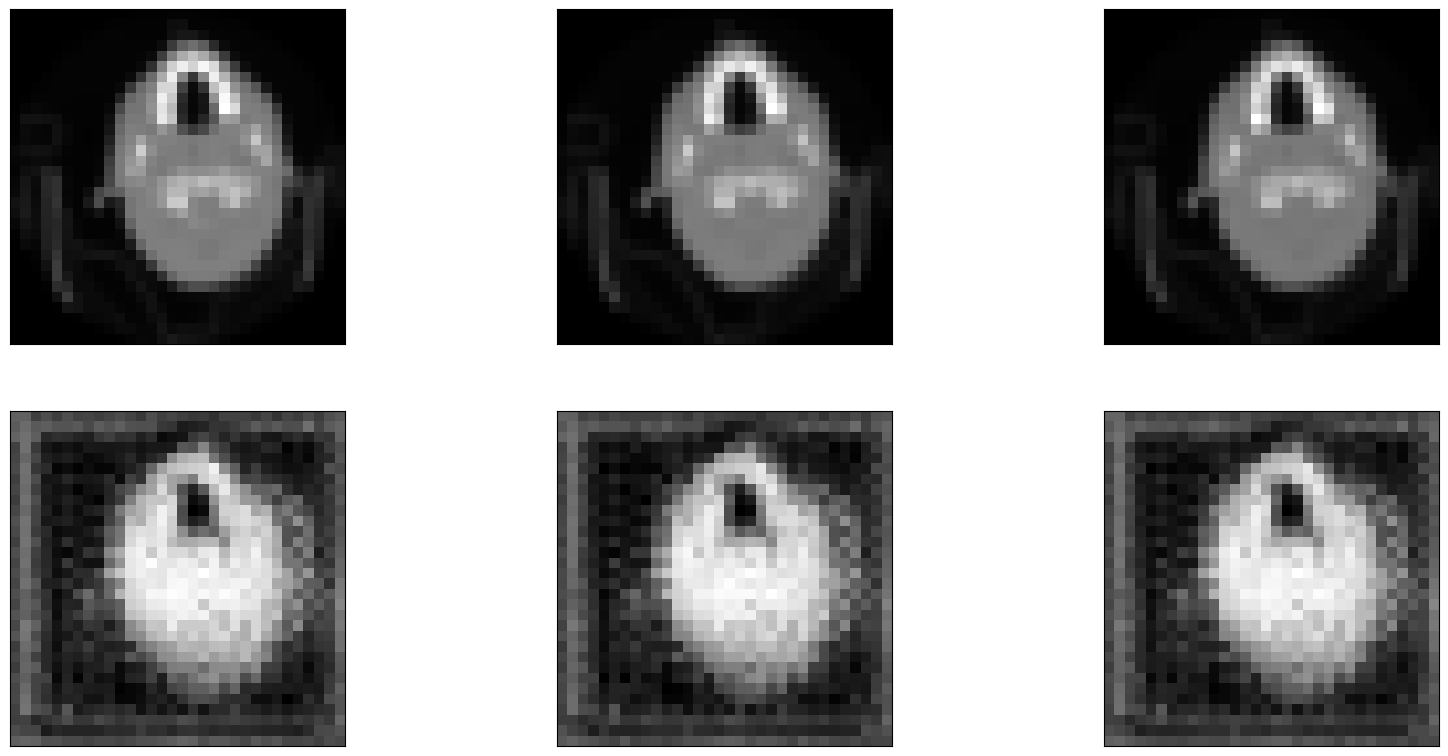

In [59]:
plt.figure(figsize=(25,25))
print(np.max(np.array(reconstruction)))
with torch.no_grad():
    number = 3
    plt.figure(figsize=(20, 20))
    for index in range(number):
        # display original
        ax = plt.subplot(4, number, index + 1)
        plt.imshow(test_examples[index])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, number, index + 1 + number)
        plt.imshow(reconstruction[index])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [60]:
test_examples = test_examples * max_value
reconstruction = reconstruction * max_value

In [61]:
print(reconstruction.max())
show_ratio = 0
v, f = make_mesh(test_examples, show_ratio,1)
plt_3d(v, f, 'test_examples.stl')
v, f = make_mesh(reconstruction, show_ratio,1)
plt_3d(v, f, 'reconstraction.stl')

815.94324


ValueError: Surface level must be within volume data range.